In [24]:
from sklearn import datasets
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.layers import Layer, InputSpec, ReLU, BatchNormalization
from tensorflow.keras.initializers import Ones
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

#this function just clips values to a range (elementwise)
class Between(Constraint):
    def __init__(self, min_value, max_value):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, w):        
        return K.clip(w, self.min_value, self.max_value)

    def get_config(self):
        return {'min_value': self.min_value,
                'max_value': self.max_value}

In [25]:
def to_list(x, allow_tuple=False):
    """Normalizes a list/tensor into a list.
    If a tensor is passed, we return
    a list of size 1 containing the tensor.
    # Arguments
        x: target object to be normalized.
        allow_tuple: If False and x is a tuple,
            it will be converted into a list
            with a single element (the tuple).
            Else converts the tuple to a list.
    # Returns
        A list.
    """
    if isinstance(x, list):
        return x
    if allow_tuple and isinstance(x, tuple):
        return list(x)
    return [x]

In [347]:
class Tent(Layer):
    """Tent activation Unit.
    It follows:
    `f(x) =  max( 0, theta -|x|) ,

    where `theta` is a learned array with the same shape as x.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as the input.
    # Arguments
        theta_initializer: initializer function for the weights.
        theta_regularizer: L2 regularization strenth
        theta_max: highest allowed value for theta (min value is set to 0.05)
        shared_axes: the axes along which to share learnable
            parameters for the activation function.
            For example, if the incoming feature maps
            are from a 2D convolution
            with output shape `(batch, height, width, channels)`,
            and you wish to share parameters across space
            so that each filter only has one set of parameters,
            set `shared_axes=[1, 2]`.
    # References
    https://arxiv.org/pdf/1908.02435.pdf
    """

    def __init__(self,
                 theta_regularizer=0.12,
                 theta_max=1.0,
                 shared_axes=None,
                 **kwargs):
        super(Tent, self).__init__(**kwargs)
        self.supports_masking = True # Do not know what this does, just let it be
        self.theta_initializer = Ones() #see article
        self.theta_regularizer = l2(theta_regularizer) # I interpreted "weight decay" as l2, not l1 
        self.theta_constraint = Between(min_value=0.05,max_value=theta_max)

        if shared_axes is None:
            self.shared_axes = None
        else:
            self.shared_axes = to_list(shared_axes, allow_tuple=True)

    def build(self, input_shape):
        param_shape = list(input_shape[1:])
        self.param_broadcast = [False] * len(param_shape)
        if self.shared_axes is not None:
            for i in self.shared_axes:
                param_shape[i - 1] = 1
                self.param_broadcast[i - 1] = True
        self.theta = self.add_weight(shape=param_shape,
                                     name='theta',
                                     initializer=self.theta_initializer,
                                     regularizer=self.theta_regularizer,
                                     constraint=self.theta_constraint)
        # Set input spec
        axes = {}
        if self.shared_axes:
            for i in range(1, len(input_shape)):
                if i not in self.shared_axes:
                    axes[i] = input_shape[i]
        self.input_spec = InputSpec(ndim=len(input_shape), axes=axes)
        self.built = True

    def call(self, inputs, mask=None):
        pos = K.relu(self.theta - tf.abs(inputs))
        return pos 

    #TODO: what is this config for? Proabably should update this to add "theta_max"
    def get_config(self):
        config = {
            'theta_initializer': initializers.serialize(self.theta_initializer),
            'theta_regularizer': regularizers.serialize(self.theta_regularizer),
            'shared_axes': self.shared_axes
        }
        base_config = super(Tent, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [348]:
model = Sequential([
    Dense(100, input_shape=(4000,2)),
    #BatchNormalization(),
    Tent(shared_axes=[0,1,2]), # ReLu / Tent
    #Dense(75),
    #BatchNormalization(),
    #Tent(shared_axes=[0,1,2]), # ReLu / Tent
    Dense(2), #Proovida pärast seda TENT + BatchNorm. Tent'i laius suuremaks
    #Tent(shared_axes=[0,1,2])
])

# Illustreerida node'i väärtusi enne/pärast Tent'i (eelviimane). Vaadata weight'e, mis väljuvad. 
# Weight'ide suhe. Kataloog pilte, iga node'i kohta eraldi pilt. - Pildid Drive või Sync
# Proovida eemaldada üks hidden layer

optimizer = Adam(learning_rate=0.01)

In [349]:
dim = 2
# More noise in the moons makes the task harder
X, y = datasets.make_moons(n_samples=2000, shuffle=True, noise=.02) # Luua test set ja vaadata täpsust. Proovida Node'e väiksemaks võtta
# Rescale and shift the dataset to better fit into zero-one box
X = (X + 1.6) / 4
X[:, 0] = X[:, 0] - 0.035
X[:, 1] = (X[:, 1] - 0.17) * 1.75

In [350]:
X_test, y_test = datasets.make_moons(n_samples=400, shuffle=True, noise=.02)
X_test = (X_test + 1.6) / 4
X_test[:, 0] = X_test[:, 0] - 0.035
X_test[:, 1] = (X_test[:, 1] - 0.17) * 1.75

In [351]:
y = tf.one_hot(y, dim)

In [352]:
def cross_ent(probs, y): #
    losses = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
    return tf.reduce_mean(losses)


def max_conf(logits):
    y = tf.argmax(logits, 1)
    y = tf.one_hot(y, dim)
    losses = -tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
    return tf.reduce_mean(losses)

In [353]:
def gen_adv(x):
    eps = 0.025
    n_iters = 4
    step_size = 0.02

    unif = tf.random.uniform(minval=-eps, maxval=eps, shape=tf.shape(x))
    x_adv = tf.clip_by_value(x + unif, 0., 1.)
    
    for i in range(n_iters):
        x_adv = tf.Variable(x_adv)
        with tf.GradientTape() as tape:
            loss = max_conf(model(x_adv))
            grad = tape.gradient(loss, x_adv)
            g = tf.sign(grad)

        x_adv_start = x_adv + step_size*g
        x_adv = tf.clip_by_value(x_adv, 0., 1.)
        delta = x_adv - x_adv_start
        delta = tf.clip_by_value(delta, -eps, eps)
        x_adv = x_adv_start + delta

    return x_adv

In [354]:
acet = True

In [355]:
if acet:
    n_iter = 600
else:
    n_iter = 600

In [356]:
# Custom training cycle going through the entire dataset
for epoch in range(1, n_iter+1):
    X_noise = tf.random.uniform([2*X.shape[0], X.shape[1]]) # Proovida ka kasutada ainult X_noise ilma gen_adv
    # If we use the ACET method, then adversarial noise will be generated
    if acet:
        X_noise = gen_adv(X_noise)
    # Context used to calculate the gradients of the model
    with tf.GradientTape() as tape:
        logits = model(X)
        logits_noise = model(X_noise)
        loss_main = cross_ent(logits, y)
        loss_acet = acet * max_conf(logits_noise)
        loss = loss_main + loss_acet
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 100  == 0:
        train_err = np.mean(logits.numpy().argmax(1) != y.numpy().argmax(1))
        print("Iter {:03d}: loss_main={:.3f} loss_acet={:.3f} err={:.2%}"
              .format(epoch, loss_main, loss_acet, train_err))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Iter 100: loss_main=0.576 loss_acet=-0.573 err=14.10%
Iter 200: loss_main=0.636 loss_acet=-0.648 err=13.35%
Iter 300: loss_main=0.602 loss_acet=-0.623 err=12.35%
Iter 400: loss_main=0.557 loss_acet=-0.592 err=11.80%
Iter 500: loss_main=0.503 loss_acet=-0.554 err=11.50%
Iter 600: loss_main=0.455 loss_acet=-0.532 err=10.65%


In [357]:
test_accuracy = tf.keras.metrics.Accuracy()


for idx in range(len(X_test)):
    sample_test = X_test[idx]
    target_test = y_test[idx]

    # Adding batch dim since batch=1
    sample_test = np.expand_dims(sample_test, axis=0)
    target_test = np.expand_dims(target_test, axis=0)

    # To tensors
    sample_test = K.constant(sample_test)
    target_test = K.constant(target_test)
        
    logits = model(sample_test)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    #print(prediction.shape)
    #print(target_test.shape)
    test_accuracy(prediction, target_test)
    

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 89.000%


In [358]:
def plot(model, plot_min, plot_max, max_prob):
    n_grid = 200
    x_plot = np.linspace(plot_min, plot_max, n_grid)
    y_plot = np.linspace(plot_min, plot_max, n_grid)
    
    points = []
    for xx in x_plot:
        for yy in y_plot:
            points.append((yy, xx))
    points = np.array(points)
    
    logits = model(points)
    probs = tf.nn.softmax(logits).numpy()
    if max_prob:
        z_plot = probs.max(1)
    else:
        z_plot = probs[:, 0]
    z_plot = z_plot.reshape(len(x_plot), len(y_plot)) * 100
    
    ax = plt.gca()
    
    vmax = 100
    vmin = 50 if max_prob else 0
    plt.contourf(x_plot, y_plot, z_plot, levels=np.linspace(50, 100, 50))
    cbar = plt.colorbar(ticks=np.linspace(vmin, vmax, 6))
    
    cbar.ax.set_title('confidence', fontsize=12, pad=12)
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%', '100%'])
    
    y_np = np.array(y)
    X0 = X[y_np.argmax(1)==0]
    X1 = X[y_np.argmax(1)==1]
    plt.scatter(X0[:, 0], X0[:, 1], s=20, edgecolors='red', facecolor='None',
                marker='o', linewidths=0.2)
    plt.scatter(X1[:, 0], X1[:, 1], s=20, edgecolors='green', facecolor='None',
                marker='s', linewidths=0.2)
    plt.xlim([plot_min, plot_max])
    plt.ylim([plot_min, plot_max])
    
    margin = 0.01
    rect = matplotlib.patches.Rectangle((-margin, -margin), 1.0+2*margin, 1.0+2*margin, 
                                        linewidth=1.5, color='white', fill=False)
    ax.add_patch(rect)
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('plots/dense100_tent_dense2_acet={}_{:.1f}_{:.1f}_max_prob={}.pdf'.format(
        acet, plot_min, plot_max, max_prob), transparent=True)
    plt.show()

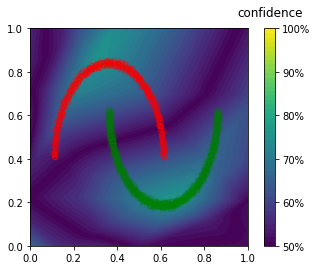

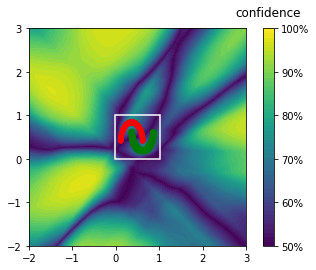

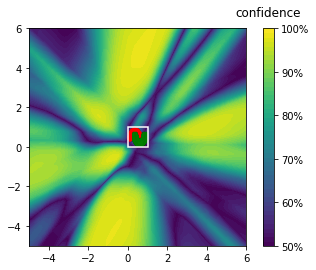

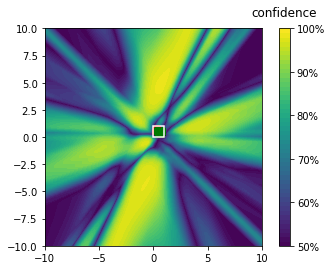

In [359]:
plot(model, 0.0, 1.0, max_prob=True)
plot(model, -2.0, 3.0, max_prob=True)
plot(model, -5.0, 6.0, max_prob=True)
plot(model, -10.0, 10.0, max_prob=True)